<h1>Buying a home in Toronto</h1>

<h2>Introduction</h2>

This project we will help all those who are looking to buy a home in Toronto. 

If they are thinking to move to Toronto or are newcomers, they can see:
- In which area of Toronto is cheaper to buy a home, 
- Which areas (residential or commercial) best suite their needs (schooling, amenties, etc).

<h2>Data</h2>

The data on apartments (size, number of rooms, address, and price) is collected by scraping a local website with apartment listings (torontorentals.com). Using geopy we find the coordinates for each four administrative divisions and then using Foursquare we collect the closest venues (supermarket, restaurant, park, etc.). After the data collection we can run k-means clustering to cluster the divisions into residential and commercial areas and visualize all the data on a single choropleth map.

<h4>Load dependecies</h4>

In [1]:
!pip install geocoder
!pip install folium
!pip install geopy

In [2]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import lxml
import matplotlib
# matplotlib.axes.Axes.pie
# matplotlib.pyplot.pie
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


<h4>1. Scraping website_name for rental listing data in Toronto</h4>

In [5]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [6]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [7]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [8]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M4G,North York,Downsview
freq,1,24,4


In [10]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [11]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [13]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M4G,North York,Downsview
freq,1,24,4


In [14]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [15]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

#Getting the coordinates for a postal code
get_latilong('M4G')

[43.70941386000004, -79.36309957799995]

In [16]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [17]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [18]:
df_2[df_2.Postalcode == 'M3H']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.757394,-79.442394


In [19]:
df_2.head(5)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.808626,-79.189913
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.785779,-79.157368
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765806,-79.185284
3,M1G,Scarborough,Woburn,43.771545,-79.218135
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813


In [20]:
df_2.tail(5)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
98,M9N,York,Weston,43.705496,-79.520370
99,M9P,Etobicoke,Westmount,43.696296,-79.533126
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.686887,-79.565507
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.744055,-79.581203
102,M9W,Etobicoke,"Northwest, West Humber - Clairville",43.711615,-79.588351


In [21]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


<h3>Map of Toronto</h3>

In [22]:
map_Toronto = folium.Map(location=[latitude_x, longitude_y], zoom_start=10.3)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [23]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinates of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinates of Neighborhood_1 are 43.6534817, -79.3839347.


In [24]:
# @hiddel_cell
CLIENT_ID = 'RI1A4S2X2DT2Y2QYTN1DBKYB5R5VYUJ0LBC4TCEOUA5I23YA' # my Foursquare ID
CLIENT_SECRET = 'BNRJSI1SYQEKE5ZKAAICVZ4BF1Y5WNGRWT4O5F0JYJ4Q20SJ' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: RI1A4S2X2DT2Y2QYTN1DBKYB5R5VYUJ0LBC4TCEOUA5I23YA
CLIENT_SECRET: BNRJSI1SYQEKE5ZKAAICVZ4BF1Y5WNGRWT4O5F0JYJ4Q20SJ


In [25]:
radius = 1000 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
    longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [26]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.cc', 'venue.location.city', 'venue.location.state',
       'venue.location.country', 'venue.location.formattedAddress',
       'venue.categories', 'venue.photos.count', 'venue.photos.groups',
       'venue.location.address', 'venue.location.crossStreet',
       'venue.location.postalCode', 'venue.location.neighborhood',
       'venue.venuePage.id'],
      dtype='object')

In [27]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Downtown Toronto,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",43.653232,-79.385296
1,Nathan Phillips Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",43.652270,-79.383516
2,Indigo,"[{'id': '4bf58dd8d48988d114951735', 'name': 'B...",43.653515,-79.380696
3,Chatime 日出茶太,"[{'id': '52e81612bcbc57f1066b7a0c', 'name': 'B...",43.655542,-79.384684
4,Textile Museum of Canada,"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",43.654396,-79.386500


In [29]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684
4,Textile Museum of Canada,Art Museum,43.654396,-79.386500


In [30]:
# Top 5 Amenties
a=pd.Series(nearby_venues.categories)
a.value_counts()[:5]

Coffee Shop            10
Café                    8
Japanese Restaurant     3
Theater                 3
Restaurant              3
Name: categories, dtype: int64

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)        

In [33]:
# Nearby Venues
Toronto_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [34]:
print('There are {} Uniques Categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.groupby('Neighborhood').count().head()

There are 307 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,26,26,26,26,26,26
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",27,27,27,27,27,27
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24


In [35]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_onehot.head(5)

,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restau

In [36]:
num_top_venues = 5
for hood in Toronto_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0       Shopping Mall  0.12
1  Chinese Restaurant  0.08
2           Pool Hall  0.04
3    Sushi Restaurant  0.04
4                Bank  0.04


---- Alderwood, Long Branch ----
            venue  freq
0     Coffee Shop  0.14
1  Sandwich Place  0.14
2             Pub  0.14
3     Gas Station  0.14
4     Pizza Place  0.14


---- Bathurst Manor, Wilson Heights, Downsview North ----
            venue  freq
0            Bank  0.07
1            Park  0.07
2     Coffee Shop  0.07
3  Ice Cream Shop  0.04
4   Shopping Mall  0.04


---- Bayview Village ----
                        venue  freq
0                        Park   0.6
1  Construction & Landscaping   0.2
2                       Trail   0.2
3                 Yoga Studio   0.0
4                 Music Store   0.0


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0      Sandwich Place  0.08
1         Coffee Shop  0.08
2          Restaurant  0.08
3  Italian Restaurant  0.08

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
import numpy as np
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Malay Restaurant,Sandwich Place,Supermarket
1,"Alderwood, Long Branch",Coffee Shop,Pub,Gas Station,Gym,Pharmacy
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Coffee Shop,Bank,Pizza Place,Deli / Bodega
3,Bayview Village,Park,Construction & Landscaping,Trail,Women's Store,Ethiopian Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Italian Restaurant,Sandwich Place,Comfort Food Restaurant


In [39]:
# Using K-Means to cluster neighborhood into 3 clusters
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Toronto_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

In [40]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(Toronto_grouped_clustering)
labels = k_means.labels_

print(labels)

[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 2 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1]


In [41]:
#df_2["Labels"] = labels
#df.head(5)

In [42]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) #if error, enter 'Cluster Labels' after 0

Toronto_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head(5)# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.808626,-79.189913,1,Park,Trail,Women's Store,Distribution Center,Dog Run
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.785779,-79.157368,0,Bar,Home Service,Fish & Chips Shop,Park,Ethiopian Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765806,-79.185284,0,Pizza Place,Electronics Store,Park,Coffee Shop,Greek Restaurant
3,M1G,Scarborough,Woburn,43.771545,-79.218135,0,Coffee Shop,Business Service,Park,Women's Store,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813,0,Thai Restaurant,Gas Station,Athletics & Sports,Hakka Restaurant,Bank


<h3>Map of Clusters</h3>

In [43]:
kclusters = 103

In [44]:
df1=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0,Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]
df2=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1,Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]
df3=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2,Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]

In [45]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

# add markers to the map
#markers_colors = []
#for lat, lon, nei , cluster in zip(Toronto_merged['Latitude'], 
#                                   Toronto_merged['Longitude'], 
#                                   Toronto_merged['Neighborhood'], 
#                                   Toronto_merged['Cluster Labels']):
#    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters) 
       
map_clusters

['#8000ff', '#7c06ff', '#7610ff', '#7216ff', '#6c1fff', '#6826fe', '#622ffe', '#5e35fe', '#583efd', '#5444fd', '#4e4dfc', '#4a53fb', '#445cfb', '#4062fa', '#396bf9', '#3670f8', '#3079f7', '#2c7ef7', '#2686f5', '#218cf4', '#1c93f3', '#1898f2', '#11a0f1', '#0ea5ef', '#08acee', '#04b0ed', '#02b7eb', '#07bbea', '#0dc2e8', '#10c6e6', '#17cbe4', '#1acfe3', '#20d5e1', '#24d8df', '#2adddd', '#2fe0db', '#34e4d9', '#38e7d7', '#3febd5', '#42edd3', '#48f1d0', '#4df3ce', '#52f5cb', '#56f7ca', '#5df9c7', '#60fac5', '#66fcc2', '#6afdc0', '#70febc', '#74feba', '#7affb7', '#80ffb4', '#84ffb2', '#8bfeae', '#8efeac', '#94fda8', '#99fca6', '#9efaa2', '#a2f9a0', '#a8f79c', '#acf59a', '#b2f396', '#b6f193', '#bced8f', '#c0eb8d', '#c6e789', '#cbe486', '#d0e082', '#d4dd80', '#dbd87b', '#ded579', '#e4cf74', '#e8cb72', '#eec66d', '#f2c26b', '#f9bb66', '#fcb763', '#ffb05f', '#ffac5c', '#ffa558', '#ffa055', '#ff9850', '#ff934d', '#ff8c49', '#ff8646', '#ff7e41', '#ff793e', '#ff703a', '#ff6b37', '#ff6232', '#ff5c2f'

In [46]:
Toronto_Avg_HousingPrice=pd.DataFrame({"Postalcode":df_2["Postalcode"],
                                      "Average_Housing_Price":[3.5*335000.0,3.5*286600.0,4.5*175000.0,3.5*225900.0,3.5*219400.0,
                                                               3.5*573900.0,3.5*225000.0,3.5*370500.0,3.5*370500.0,3.5*433500.0,3.5*279200.0,
                                                               3.5*279200.0,3.5*225000.0,3.5*370500.0,3.5*255400.0,3.5*433500.0,3.5*433500.0,
                                                               3.5*435000.0,3.5*289500.0,3.5*265000.0,3.5*285900.0,3.5*239400.0,
                                                               3.5*589900.0,3.5*295000.0,3.5*380500.0,3.5*378500.0,3.5*438500.0,3.5*229200.0,
                                                               3.5*229200.0,3.5*365000.0,3.5*388500.0,3.5*285400.0,3.5*493500.0,3.5*477500.0,3.5*378000.0,3.5*316600.0,3.5*195000.0,3.5*225900.0,3.5*219400.0,
                                                               3.5*573900.0,3.5*367000.0,3.5*370500.0,3.5*370500.0,3.5*363500.0,3.5*279200.0,
                                                               3.5*279200.0,3.5*271000.0,3.5*370500.0,3.5*255400.0,3.5*383500.0,3.5*433500.0,3.5*335000.0,3.5*286600.0,3.5*185000.0,3.5*225900.0,3.5*219400.0,
                                                               3.5*573900.0,3.5*329000.0,3.5*370500.0,3.5*370500.0,3.5*533500.0,3.5*279200.0,
                                                               3.5*279200.0,3.5*375000.0,3.5*370500.0,3.5*255400.0,3.5*493500.0,3.5*433500.0,3.5*335000.0,3.5*286600.0,3.5*165000.0,3.5*225900.0,3.5*219400.0,
                                                               3.5*573900.0,3.5*425000.0,3.5*370500.0,3.5*370500.0,3.5*433500.0,3.5*279200.0,
                                                               3.5*279200.0,3.5*195000.0,3.5*370500.0,3.5*255400.0,3.5*403500.0,3.5*433500.0,3.5*335000.0,3.5*286600.0,3.5*187000.0,3.5*225900.0,3.5*219400.0,
                                                               3.5*573900.0,3.5*325000.0,3.5*370500.0,3.5*370500.0,3.5*333500.0,3.5*279200.0,
                                                               3.5*279200.0,3.5*289000.0,3.5*370500.0,3.5*255400.0,3.5*413500.0,3.5*433500.0,3.5*254800.0
                                                              ]})

In [47]:
Toronto_Avg_HousingPrice.set_index('Postalcode',inplace=True,drop=True)

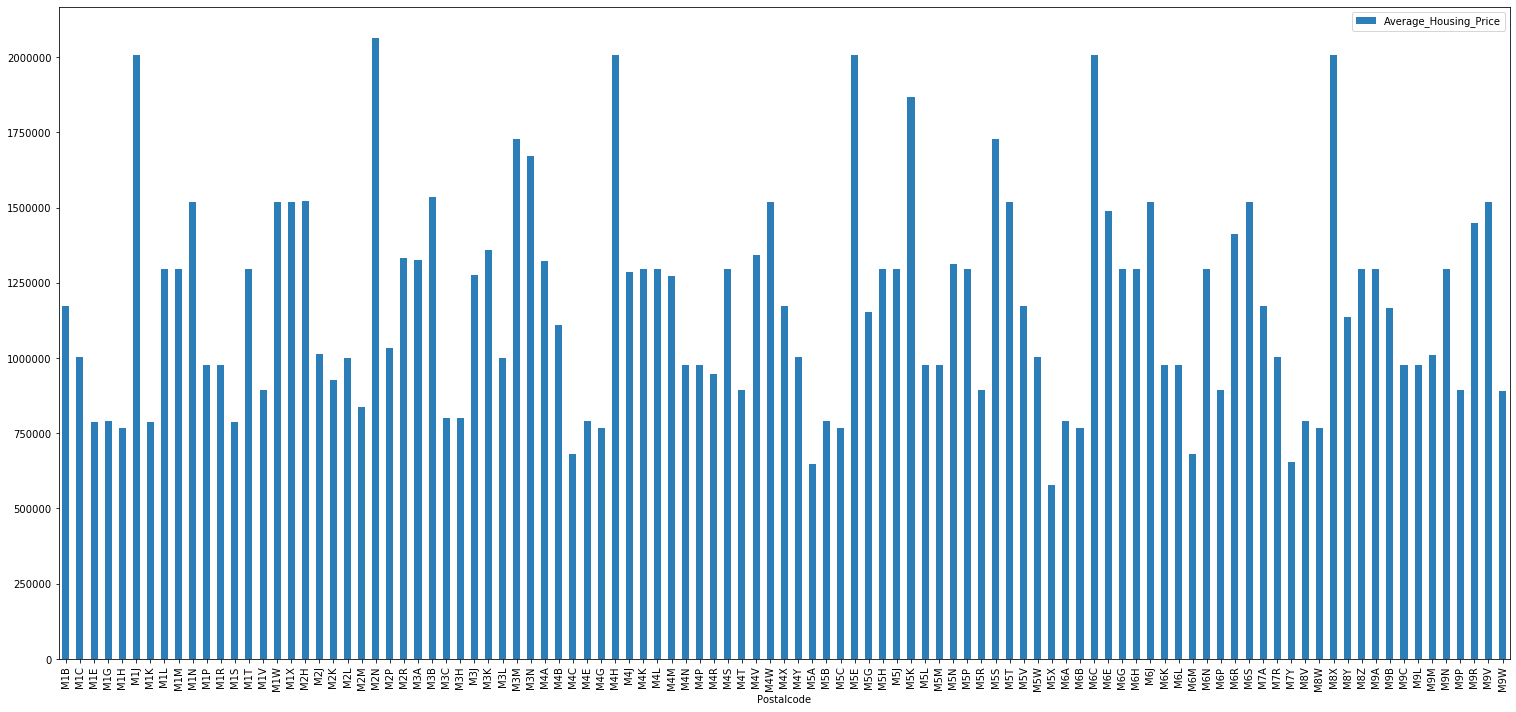

In [48]:
Toronto_Avg_HousingPrice.plot(kind='bar',figsize=(26,12),alpha=0.95).get_figure().savefig('house_prices.pdf')

<h3>School Rating by Clusters</h3>

In [49]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [50]:
new_Toronto=Toronto_merged.set_index("Postalcode",drop=True)
#Source:https://www.greatschools.org
Toronto_school_ratings=pd.DataFrame({"Postalcode":df["Postalcode"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [51]:
Toronto_school_ratings.set_index('Postalcode',inplace=True,drop=True)

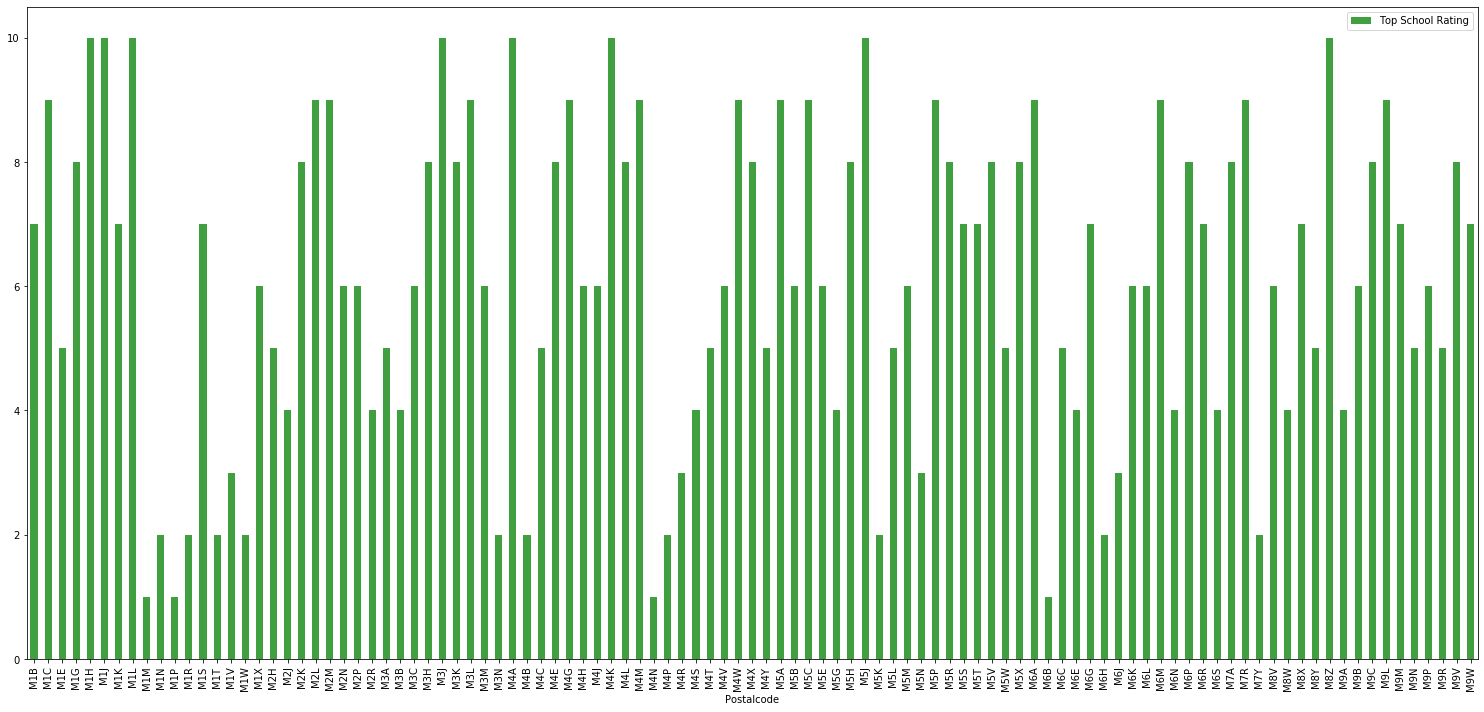

In [52]:
Toronto_school_ratings.plot(kind='bar',figsize=(26,12),color='green',alpha=0.75).get_figure().savefig('schools_plot.pdf');